# Improving results by [Zhuo et al.](https://pubs.acs.org/doi/10.1021/acs.jpclett.8b00124)

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing


%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
from sklearn.metrics import accuracy_score
import pymatgen as mg
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import statistics


from deap import creator, base, tools, algorithms
import random
import warnings

In [5]:
#read experimental band gap data with features taken from https://github.com/BrgochGroup/BandGapPredictor
df_merge = pd.read_excel('/home/dima/Desktop/ML/Zhau et al/Training_Set.xlsx',sheet_name=1)

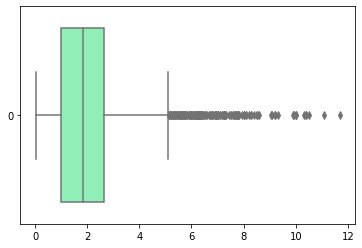

In [6]:
# See the outliers
sns.boxplot(data=df_merge['Eg'], palette='rainbow', orient='h');

The most of the compounds have bang gap values smaller then 4 eV. 
In what follows we are going to use RMSE to evaluate ML model preformance. RMSE is very sensible to large errors for a given prediction as it involves squares of error values.
Analysis shows that ML model we are going to construct performs well for compounds with bg<4. So, it is reasonable to define a new feature 'bg>4', which indicates whether band gap for a given compound is smaller or greater of 4 eV

In [11]:
# Define a new target
df_merge['bg>4'] = np.nan
for i in range(0,len(df_merge['Eg'])):
    if df_merge['Eg'][i]>4:
        df_merge['bg>4'][i]=int(1)
    else:
        df_merge['bg>4'][i]=int(0)
        
df_merge['metal'] = np.nan
for i in range(0, len(df_merge['Eg'])):
    if df_merge['Eg'][i] < 0.0001:
        df_merge['metal'][i]=int(1)
    else:
        df_merge['metal'][i]=int(0)

The band gap data is skewed


 mu = 2.04 and sigma = 1.50



Text(0.5, 1.0, 'Band gap value')

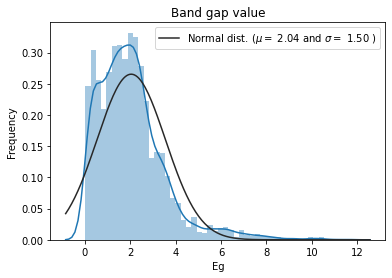

In [21]:
from scipy.stats import norm, skew 
from scipy import stats
sns.distplot(df_merge['Eg'], fit=norm);

(mu, sigma) = norm.fit(df_merge['Eg'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Band gap value')

When using machine leaning algorithms (at least linear) it is better to make data to have a not skewed normal distribution by performing log-transformation.
I performed such a transformation, but it turned out that XGBoost, that we are using here, performs poorly with this transformed data (probably, because it is based on nonlinear algorithms). 

## Classification: bg>4

Here we are going to predict whether a given compound has bg>4

In [211]:
features = []
for col in df_merge.columns:
    features+=[str(col)]
to_remove = ['Eg', 'Composition', 'metal', 'bg>4']
for i in to_remove:
    features.remove(i)
    
X = df_merge[features]
y = df_merge['bg>4']

#### Genetic algorithm for feature selection

We will use DEAP module for the genetic algorithm for feature selection. The code written below is a modification of the code taken from [here](https://github.com/scoliann/GeneticAlgorithmFeatureSelection/blob/master/gaFeatureSelectionExample.py). 
Define some useful functions

In [111]:
def custom_cv(X, y, clf, n_shuf=30,):
    X = X.values
    Y = y.values
    acc = []
    for i in range(0, n_shuf):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=random.randint(1,100))
        #preprocessing
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        clf = clf.fit(X_train, Y_train)
        predicted_Y = clf.predict(X_test)
        #predicted_Y_r = np.exp(regression.predict(X_test_r))-1
        #Y_test_r=np.exp(Y_test_r)-1
        ac = accuracy_score(predicted_Y, Y_test)
        acc.append(ac)
    return statistics.mean(acc)

def getFitness(individual, X ,y):
    # Parse our feature columns that we don't use
    cols = [index for index in range(len(individual)) if individual[index] == 0]
    X_Parsed = X.drop(X.columns[cols], axis=1)
    
    # Calculate accuracy
    clf = XGBClassifier()
    accuracy = custom_cv(X_Parsed, y, clf)
    # Return calculated accuracy as fitness
    return (accuracy,)

In [197]:
# This function gives hall of fame (the set of individuals with the best performance)
def getHof(numPop = 100, numGen = 8):

    # Initialize variables to use eaSimple
    pop = toolbox.population(n=numPop)
    hof = tools.HallOfFame(numPop * numGen)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Launch genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof, verbose=True)

    # Return the hall of fame
    return hof

def getMetrics(hof):    
    # Gather fitness data
    AccuracyList = []
    individualList = []
    for individual in hof:
        Accuracy = getFitness(individual, X, y)
        AccuracyList.append(Accuracy[0])
        individualList.append(individual)
        
    return AccuracyList, individualList

In [113]:
"""
This defines strategy of the genetic algorithm. The genetic algorithm is tuned in such a way that during the evolution the accuracy value should have its maximum value
"""
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(df_merge.columns) - len(to_remove))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox...
toolbox.register("evaluate", getFitness, X=X, y=y)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [114]:
'''
First, we will apply XGBoost classifier using all the features to acquire a baseline accuracy.
'''
individual = [1 for i in range(len(X.columns))]
Accuracy = getFitness(individual, X, y)
print('\nAccuracy with all features: \t' + str(Accuracy[0]))

'''
Now, we will apply a genetic algorithm to choose a subset of features that gives a better accuracy than the baseline.
'''
hof = getHof()


Accuracy with all features: 	0.9773504273504273
gen	nevals	avg     	std       	min     	max     
0  	100   	0.974415	0.00151648	0.970085	0.978034
1  	64    	0.975021	0.00157151	0.971624	0.978034
2  	57    	0.975682	0.00156036	0.970427	0.980427
3  	57    	0.976146	0.00196239	0.969487	0.980427
4  	63    	0.976245	0.00184307	0.972393	0.980427
5  	61    	0.976728	0.00186783	0.972137	0.980427
6  	51    	0.976812	0.00200053	0.972479	0.980427
7  	76    	0.976221	0.00187572	0.972222	0.980427
8  	70    	0.976523	0.00166992	0.972222	0.980427


In [ ]:
AccuracyList, individualList = getMetrics(hof)
# Get a list of subsets that performed best on validation data 
maxValAccSubsetIndicies = [index for index in range(len(AccuracyList)) if AccuracyList[index] == max(AccuracyList)]
maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
maxValSubsets = [[list(features)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]

print('\n---Optimal Feature Subset(s)---\n')
for index in range(len(maxValAccSubsetIndicies)):
    #print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
    print('Accuracy: \t\t' + str(AccuracyList[maxValAccSubsetIndicies[index]]))
    print('Individual: \t' + str(maxValIndividuals[index]))
    print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
    print('Feature Subset: ' + str(maxValSubsets[index]))

In [125]:
features_optimal_bg4 = ['avg_Atomic number', 'avg_Family number', 'avg_L quantum number', 'avg_Mendeleev number', 'avg_Atomic radius (Å)', 'avg_Covalent radius (Å)', 'avg_Zunger radius (Å)', 'avg_Ionic radius (Å)', 'avg_Pauling EN', 'avg_Martynov-Batsanov EN', 'avg_Allen EN', 'avg_Metallic valence', 'avg_Number of valence electrons', 'avg_Number of s electrons', 'avg_Number of p electrons', 'avg_Number of d electrons', 'avg_First ionization energy (kJ/mol)', 'avg_Polarizability', 'avg_Specific heat (J/g•K)', 'avg_Heat of fusion (kJ/mol)', 'avg_Heat of vaporization (kJ/mol)', 'avg_Heat atomization (kJ/mol)', 'diff_Atomic number', 'diff_Atomic weight', 'diff_Family number', 'diff_L quantum number', 'diff_Mendeleev number', 'diff_Atomic radius (Å)', 'diff_Covalent radius (Å)', 'diff_Zunger radius (Å)', 'diff_Crystal radius (Å)', 'diff_Metallic valence', 'diff_Number of s electrons', 'diff_Number of d electrons', 'diff_First ionization energy (kJ/mol)', 'diff_Polarizability', 'diff_Boiling point (K)', 'diff_Specific heat (J/g•K)', 'diff_Heat of fusion (kJ/mol)', 'diff_Heat of vaporization (kJ/mol)', 'diff_Heat atomization (kJ/mol)', 'diff_Cohesive energy (eV)', 'max_Atomic number', 'max_Family number', 'max_L quantum number', 'max_Covalent radius (Å)', 'max_Zunger radius (Å)', 'max_Ionic radius (Å)', 'max_Pauling EN', 'max_Martynov-Batsanov EN', 'max_Gordy EN', 'max_Mulliken EN', 'max_Allen EN', 'max_Number of valence electrons', 'max_Number of d electrons', 'max_Number of outer shell electrons', 'max_Polarizability', 'max_Melting point (K)', 'max_Boiling point (K)', 'max_Specific heat (J/g•K)', 'max_Heat of vaporization (kJ/mol)', 'max_Thermal conductivity (W/m•K)', 'max_Heat atomization (kJ/mol)', 'max_Cohesive energy (eV)', 'min_Atomic weight', 'min_Period number', 'min_L quantum number', 'min_Mendeleev number', 'min_Atomic radius (Å)', 'min_Covalent radius (Å)', 'min_Ionic radius (Å)', 'min_Crystal radius (Å)', 'min_Pauling EN', 'min_Martynov-Batsanov EN', 'min_Gordy EN', 'min_Allen EN', 'min_Number of d electrons', 'min_Number of outer shell electrons', 'min_First ionization energy (kJ/mol)', 'min_Polarizability', 'min_Specific heat (J/g•K)', 'min_Heat atomization (kJ/mol)', 'min_Cohesive energy (eV)']

Now we want to find the optimal set of hyperparameters for the XGBClassifier algo

In [212]:
from sklearn.model_selection import StratifiedKFold

paramgrid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


random.seed(1)

from evolutionary_search import EvolutionaryAlgorithmSearchCV
estimator = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)
cv = EvolutionaryAlgorithmSearchCV(estimator=estimator,
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=20, random_state = random.randint(1,100)),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
cv.fit(X, y)

Types [1, 2, 2, 2, 1] and maxint [2, 4, 2, 2, 2] detected
--- Evolve in 405 possible combinations ---
gen	nevals	avg     	min     	max     	std       
0  	50    	0.972233	0.968429	0.976129	0.00169769
1  	35    	0.973701	0.969713	0.976129	0.00156652
2  	30    	0.974671	0.972023	0.976129	0.00115639
3  	20    	0.975524	0.973306	0.976643	0.000747021
4  	26    	0.975606	0.969456	0.976643	0.00113281 
5  	29    	0.975873	0.972279	0.977413	0.000899457
Best individual is: {'min_child_weight': 1, 'gamma': 0.5, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 5}
with fitness: 0.9774127310061602


## Regression model for band gap prediction

In [213]:
features = []
for col in df_merge.columns:
    features+=[str(col)]
to_remove = ['Eg', 'Composition', 'metal', 'bg>4']
for i in to_remove:
    features.remove(i)
    
X = df_merge[features]
y = df_merge['Eg']
#y=np.log(1+y)

### Genetic algo for features selection

In [214]:
def rmse_cv_custom(X, y, test_size=0.1, n_shuffle=40):
    rand_num = random.randint(1,100)
    RMSE = []
    for i in range(0, n_shuffle):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random.randint(1,100))
        model = XGBRegressor().fit(X_train, y_train)
        rmse = np.sqrt(mean_squared_error(abs(model.predict(X_test)), y_test))
        RMSE.append(rmse)
    return statistics.mean(RMSE)

In [215]:
def getFitness(individual, X ,y):
    # Parse our feature columns that we don't use
    cols = [index for index in range(len(individual)) if individual[index] == 0]
    X_Parsed = X.drop(X.columns[cols], axis=1)
    
    # Calculate RMSE 
    RMSE = rmse_cv_custom(X_Parsed, y)
    # Return calculated accuracy as fitness
    return (RMSE,)

# Change the weight to -1. With this condition the algorithm will be searching for a minimum
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(df_merge.columns) - len(to_remove))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox...
toolbox.register("evaluate", getFitness, X=X, y=y)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
'''
First, we will apply XGBoost regressor using all the features to acquire a baseline accuracy.
'''
individual = [1 for i in range(len(X.columns))]
Accuracy = getFitness(individual, X, y)
print('\nAccuracy with all features: \t' + str(Accuracy[0]))

'''
Now, we will apply a genetic algorithm to choose a subset of features that gives a better accuracy than the baseline.
'''
hof = getHof(numGen = 40)
AccuracyList, individualList = getMetrics(hof)
# Get a list of subsets that performed best on validation data 
minValAccSubsetIndicies = [index for index in range(len(AccuracyList)) if AccuracyList[index] == min(AccuracyList)]
minValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
minValSubsets = [[list(features)[index] for index in range(len(individual)) if individual[index] == 1] for individual in minValIndividuals]

print('\n---Optimal Feature Subset(s)---\n')
for index in range(len(maxValAccSubsetIndicies)):
    #print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
    print('Accuracy: \t\t' + str(AccuracyList[minValAccSubsetIndicies[index]]))
    print('Individual: \t' + str(minValIndividuals[index]))
    print('Number Features In Subset: \t' + str(len(minValSubsets[index])))
    print('Feature Subset: ' + str(minValSubsets[index]))

In [193]:
features_optimal_bg = ['avg_Group number', 'avg_Family number', 'avg_L quantum number', 'avg_Mendeleev number', 'avg_Covalent radius (Å)', 'avg_Ionic radius (Å)', 'avg_Crystal radius (Å)', 'avg_Martynov-Batsanov EN', 'avg_Allen EN', 'avg_Metallic valence', 'avg_Number of valence electrons', 'avg_Number of s electrons', 'avg_Number of d electrons', 'avg_Melting point (K)', 'avg_Specific heat (J/g•K)', 'avg_Heat atomization (kJ/mol)', 'avg_Cohesive energy (eV)', 'diff_Period number', 'diff_Group number', 'diff_Covalent radius (Å)', 'diff_Zunger radius (Å)', 'diff_Ionic radius (Å)', 'diff_Crystal radius (Å)', 'diff_Martynov-Batsanov EN', 'diff_Gordy EN', 'diff_Mulliken EN', 'diff_Allen EN', 'diff_Metallic valence', 'diff_Number of valence electrons', 'diff_Number of d electrons', 'diff_First ionization energy (kJ/mol)', 'diff_Melting point (K)', 'diff_Boiling point (K)', 'diff_Density (g/mL)', 'diff_Heat of vaporization (kJ/mol)', 'diff_Heat atomization (kJ/mol)', 'diff_Cohesive energy (eV)', 'max_Atomic number', 'max_Group number', 'max_L quantum number', 'max_Zunger radius (Å)', 'max_Martynov-Batsanov EN', 'max_Mulliken EN', 'max_Metallic valence', 'max_Number of s electrons', 'max_Number of p electrons', 'max_Number of d electrons', 'max_Number of outer shell electrons', 'max_First ionization energy (kJ/mol)', 'max_Melting point (K)', 'max_Boiling point (K)', 'max_Density (g/mL)', 'max_Specific heat (J/g•K)', 'max_Thermal conductivity (W/m•K)', 'max_Heat atomization (kJ/mol)', 'min_Atomic number', 'min_Atomic weight', 'min_Period number', 'min_Mendeleev number', 'min_Atomic radius (Å)', 'min_Zunger radius (Å)', 'min_Pauling EN', 'min_Martynov-Batsanov EN', 'min_Gordy EN', 'min_Metallic valence', 'min_Number of valence electrons', 'min_Number of s electrons', 'min_Number of p electrons', 'min_Number of d electrons', 'min_Number of outer shell electrons', 'min_Boiling point (K)', 'min_Specific heat (J/g•K)', 'min_Heat of fusion (kJ/mol)', 'min_Thermal conductivity (W/m•K)', 'min_Heat atomization (kJ/mol)']

In [195]:
model = XGBRegressor()
X_reg = df_merge[features_optimal_bg]
y_reg = df_merge['Eg']
rmse_cv_custom(X_reg, y_reg).mean()

0.41287642993796936

We thus have RMSE about 0.41 eV

It can be shown that including 'bg>4' in to the features set improves the result. However, it can be generated only when we know experimental band gap values. 
Classification ML model for 'bg>4' constructed previously demonstrates great performance. So, we are going to use it in order to, first, predict 'bg>4' and then use it as a feature 
in the regression model for the band gap value prediction. To do so, we define a function


In [183]:
# The following function takes X_train and X_test, then predicts 'bg>4' (more precisely, the probability to belong to a class with bg>4), 
# add it to X_train and X_test and returns X_train and X_test with predicted 'bg>4'
def generate_bg4(X_train, X_test):
    X_train_bg4 = X_train[features_optimal_bg4]
    scaler = preprocessing.StandardScaler().fit(X_train_bg4)
    X_train_bg4 = scaler.transform(X_train_bg4)
    y_train_bg4=np.array(X_train['bg>4'].values)
    #test data
    X_test_bg4 = X_test[features_optimal_bg4]
    X_test_bg4 = scaler.transform(X_test_bg4)
    y_test_bg4 = np.array(X_test['bg>4'].values)
    
    #ML model with the optimal set of hyperparameters found above
    xgb_bg4 = XGBClassifier(min_child_weight = 1, gamma = 0.5, subsample = 0.8, colsample_bytree = 1.0, max_depth = 2).fit(X_train_bg4, y_train_bg4)

    #train data
    y_train_bg4=xgb_bg4.predict_proba(X_train_bg4)
    y_train_bg4=y_train_bg4[:,[1]]
    scaler_bg4 = preprocessing.StandardScaler().fit(y_train_bg4)
    y_train_bg4 = scaler_bg4.transform(y_train_bg4)
    y_train_bg4 = np.reshape(y_train_bg4, y_train_bg4.shape[0])
    y_train_bg4=y_train_bg4[:, np.newaxis]
    
    #test data
    y_test_bg4=xgb_bg4.predict_proba(X_test_bg4)
    y_test_bg4=y_test_bg4[:,[1]]
    y_test_bg4 = scaler_bg4.transform(y_test_bg4)
    y_test_bg4 = np.reshape(y_test_bg4, y_test_bg4.shape[0])                        
    y_test_bg4=y_test_bg4[:, np.newaxis]
    
    #combine train data into one X_train and preprocess it with the Standart scaler
    features_optimal_bg_without_bg4 = [i for i in features_optimal_bg if i!='bg>4']
    X_train_without_bg4 = X_train[features_optimal_bg_without_bg4]
    scaler = preprocessing.StandardScaler().fit(X_train_without_bg4)
    X_train_without_bg4 = scaler.transform(X_train_without_bg4)
    train_bg4 = X_train['bg>4'].values
    train_bg4=train_bg4[:, np.newaxis]
    X_train = np.append(X_train_without_bg4, y_train_bg4, axis =1)
    
    #combine test data into one X_test preprocessed with Standart scaler
    X_test_without_bg4 = X_test[features_optimal_bg_without_bg4]
    X_test_without_bg4 = scaler.transform(X_test_without_bg4)
    X_test = np.append(X_test_without_bg4, y_test_bg4, axis =1)
    
    return X_train, X_test
    
# This function returns avaraged RMSE of n_shuf cycles    
def custom_cv(X, y, test_size=0.1, n_shuf=30):
    acc = []
    rand_num = random.randint(1,60)
    for i in range(0, n_shuf):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,)
        X_train, X_test = generate_bg4(X_train, X_test) 
            
        clf = XGBRegressor().fit(X_train, y_train)
        predicted_Y=clf.predict(X_test)
        ac = np.sqrt(mean_squared_error(predicted_Y, y_test))
        acc.append(ac)
            
    return statistics.mean(acc)

We add one more feature 'bg>4' into the features_optimal_bg set. It is used only for training. The above code predicts 'bg>4' for the test data and it used then in the regression algorithm

In [175]:
features_optimal_bg = features_optimal_bg.append('bg>4')

In [186]:
X = df_merge[features_optimal_bg]
y = df_merge['Eg']

Unfortunately, this strategy doesn't show to work giving higher RMSE

In [187]:
custom_cv(X, y, test_size=0.1, n_shuf=30)

0.4688650097434145

### Results

We thus have improved the resluts obtained by [Zhuo et al.](https://pubs.acs.org/doi/10.1021/acs.jpclett.8b00124). In this paper the achived RMSE is 0.45 eV, while here we have RMSE=0.41 eV.